<a href="https://colab.research.google.com/github/Booss3my/Datascraper/blob/master/Predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.colab import drive
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torch.autograd import Variable
from torchsummary import summary
from scipy.stats import zscore
import pandas as pd

Upload dataset and model checkpoint if available


In [ ]:
uploaded = files.upload()

Saving precurseur.xlsx to precurseur.xlsx


Read and visualise data

In [ ]:
table=pd.read_excel("precurseur.xlsx")


In [ ]:
#print head
table.head()

,Reference cellule,C-Rate DCH,C-Loss,Cycles,Temps (min),dV
0,Ref_86,2xC,0.0,1,5,14.933152
1,Ref_86,2xC,0.0,1,6,14.957570
2,Ref_86,2xC,0.0,1,7,14.681274
3,Ref_86,2xC,0.0,1,8,14.969760
4,Ref_86,2xC,0.0,1,9,16.247636


Preprocessing:
- Adress NanN values
- Remove/replace outliers


In [ ]:
table.columns

Index(['Reference cellule', 'C-Rate DCH', 'C-Loss', 'Cycles', 'Temps (min)',
       'dV'],
      dtype='object')

In [ ]:
dv_df=table
NaN_number=dv_df['C-Loss'].isnull().sum()
print(NaN_number)

#drop
dv_df= dv_df.dropna()
#rename columns
dv_df.columns = ["Sample","Charge","closs",dv_df.columns[3],"minutes",dv_df.columns[5]]
dv_df.head()



0


,Sample,Charge,closs,Cycles,minutes,dV
0,Ref_86,2xC,0.0,1,5,14.933152
1,Ref_86,2xC,0.0,1,6,14.957570
2,Ref_86,2xC,0.0,1,7,14.681274
3,Ref_86,2xC,0.0,1,8,14.969760
4,Ref_86,2xC,0.0,1,9,16.247636


In [ ]:
dv_df.Sample.value_counts()

Ref_88    3009
Ref_87    2957
Ref_86    2911
Ref_92    2816
Ref_91    2796
Ref_90    2764
Name: Sample, dtype: int64

Split data into sequences 

In [ ]:
seq_length=20 #10 minutes
overlap=5 #overlap of consecutive sequences


print("charge rate 2xC",dv_df.loc[dv_df['Charge']=='2xC','Sample'].unique())
print("charge rate 4xC",dv_df.loc[dv_df['Charge']=='4xC','Sample'].unique())


#keep 'Ref_86' 'Ref_90' for testing to validate that the model didn't learn something specific to a cell in particular 
test_seq_names=['Ref_86','Ref_90']
train_seq_names=['Ref_88','Ref_87','Ref_86','Ref_92','Ref_91']



charge rate 2xC ['Ref_86' 'Ref_87' 'Ref_88']
charge rate 4xC ['Ref_90' 'Ref_91' 'Ref_92']


Helper function to split data into sequences of that have the same length and are overlaping.

The length and overlap specified as parameters

In [ ]:
from collections import defaultdict
import statistics as stat
def split_sequence(seq,seq_length,overlap):

  n=seq.shape[0]
  
  nb_seq=n//(seq_length-overlap)-10
  seq_dict=np.zeros((nb_seq,seq_length*2)) #defaultdict(list)


  for i in range(nb_seq):
    for j in range(seq_length):
      seq_dict[i][j]=seq.iloc[i*(seq_length-overlap)+j].dV
      seq_dict[i][j+seq_length]=seq.iloc[i*(seq_length-overlap)+j].closs  
    
  return seq_dict #pd.DataFrame(seq_dict)
  

In [ ]:
whole_array=np.zeros((1,2*seq_length));
for i in range(np.size(train_seq_names)):
  seq=dv_df.loc[(dv_df["Sample"] == train_seq_names[i])]
  whole_array=np.append(whole_array,split_sequence(seq,seq_length,overlap),axis=0)

train_array=torch.tensor(whole_array[2:,:seq_length])
train_target=torch.tensor(whole_array[2:,seq_length:])

whole_array=np.zeros((1,2*seq_length));
for i in range(np.size(test_seq_names)):
  seq=dv_df.loc[(dv_df["Sample"] == test_seq_names[i])]
  whole_array=np.append(whole_array,split_sequence(seq,seq_length,overlap),axis=0)
test_array=torch.tensor(whole_array[2:,:seq_length])
test_target=torch.tensor(whole_array[2:,seq_length:])

In [ ]:
print("train tensor:",train_array.shape)
print("test tensor:",test_array.shape)

train tensor: torch.Size([913, 20])
test tensor: torch.Size([357, 20])


In [ ]:
b = train_array.split(1, dim=1)
print(b[9].shape)

torch.Size([1264, 1])


Available device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64,hidden_layers2=32):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        self.hidden_layers2 = hidden_layers2 
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers2)
        self.linear = nn.Linear(self.hidden_layers2, 1)
        
    def forward(self, y, future_preds=0):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers2, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers2, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [ ]:
#hyperparameters

lr=0.01
gamma=0.7
step_size=200
alpha=0.7 #importance of last step  
train=0 
load=1 
PATH="final_model.pth" #path to checkpoint
num_epochs=10

In [ ]:
def la_sauce(outputs,targets,alpha):
    out=abs(outputs-targets).sum(axis=0)/targets.shape[0]

    loss=((1-alpha)*torch.mean(out[:-2])+alpha*out[-1])
    return loss


In [ ]:
model = LSTM()
optimiser = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size, gamma)

In [ ]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
if train:
  for epoch in range(num_epochs):
    train_data = train_array
    target_data=train_target
    # ===================forward=====================
    output = model(train_data.float())
    loss = la_sauce(output,target_data,alpha)

    # ===================backward====================
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))

#torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/10], loss:0.0121
epoch [2/10], loss:0.0120
epoch [3/10], loss:0.0121
epoch [4/10], loss:0.0120
epoch [5/10], loss:0.0120
epoch [6/10], loss:0.0120
epoch [7/10], loss:0.0120
epoch [8/10], loss:0.0120
epoch [9/10], loss:0.0120
epoch [10/10], loss:0.0120


In [ ]:
tmp=abs(model(train_array.float())[:,-1]-train_target[:,-1])
print("model train Mean Absolute Error: ",100*np.sum(tmp.detach().numpy())/tmp.shape[0],"%")


tmp=abs(model(test_array.float())[:,-1]-test_target[:,-1])
print("model test Mean Absolute Error: ",100*np.sum(tmp.detach().numpy())/tmp.shape[0],"%")

model train Mean Absolute Error:  0.3907390764668226 %
model test Mean Absolute Error:  0.45751361741913266 %


## Test data sequences 

We visualize the models predictions for number (rows*columns) of sequences.  

In orange the target C_loss sequence.
In blue the models predictions.

The x axis is the length of the sequence in the minutes.

The y axis is the Capacity Loss in (%), the scale is fixed to [0,30] 




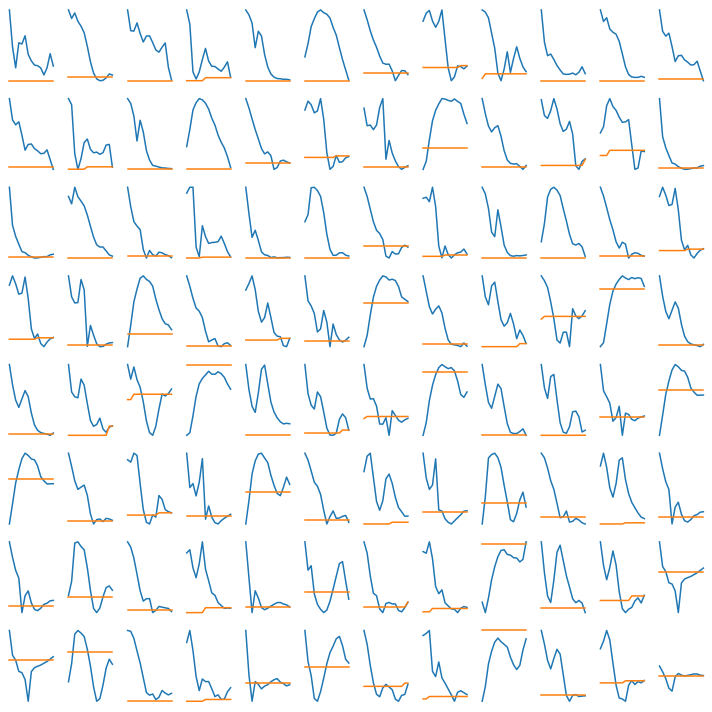

In [ ]:
rows=8
col=12
f, axs = plt.subplots(rows, col, figsize=(10, 10))
for i in range(rows):
  for j in range(col):
    idx=i*(col-1)+j   
    axs[i,j].plot(np.linspace(1,seq_length,seq_length),100*model(test_array.float())[idx,:].detach().numpy(),linspace(1,seq_length,seq_length),100*test_target[idx,:].detach().numpy())
    plt.ylim([0,30])
    axs[i,j].axis('off')
    
plt.tight_layout();

Text(0, 0.5, 'C_loss in %')

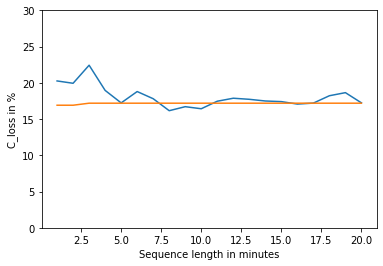

In [ ]:
idx=random.randint(0,test_array.shape[0])   
plt.plot(np.linspace(1,seq_length,seq_length),100*model(test_array.float())[idx,:].detach().numpy(),linspace(1,seq_length,seq_length),100*test_target[idx,:].detach().numpy())
plt.ylim([0,30])
plt.xlabel("Sequence length in minutes")
plt.ylabel("C_loss in %")

Save model/optimizer parameters

In [ ]:
torch.save({    'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
                }, 'final_model.pth')

## Testing the models performance for sequences of variable lengths

The model can be fed with sequences of variable length.

Let's visualize the models performance (measured by mean absolute error) tested by stopping (truncating) test sequences at different lengths.

The model reaches its minuimum error at 15 which the sequence length value used for training.

A suspect for this behaviour is the loss function that gives more weight to the error at the end of the sequence than the rest of the sequence. 

Text(0.5, 1.0, 'MAE of test predictions')

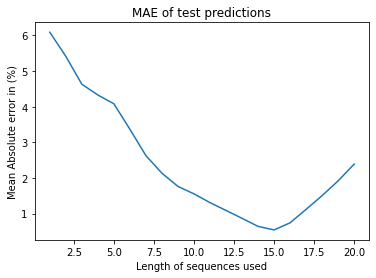

In [ ]:
MAE=np.zeros((seq_length,1))
for i in range(1,seq_length+1):
  tmp=abs(model(test_array[:,:i].float())[:,-1]-test_target[:,-1])
  MAE[i-1]=100*np.sum(tmp.detach().numpy())/tmp.shape[0]

plt.plot(np.linspace(1,seq_length,seq_length),MAE)
plt.xlabel("Length of sequences used")
plt.ylabel("Mean Absolute error in (%)")
plt.title("MAE of test predictions")